In [39]:
#pip install pandas numpy matplotlib scikit-learn

In [53]:
%matplotlib inline

In [32]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [33]:
# Load the shapefile
florida_shapefile = gpd.read_file('tl_2020_12_tract/tl_2020_12_tract.shp')

In [34]:
# Load the data
df = pd.read_csv('Florida_ct.csv')

In [35]:
# Ensure the data type matches for merging
florida_shapefile['GEOID'] = florida_shapefile['GEOID'].astype('int64')
df['full_ct_fips'] = df['full_ct_fips'].astype('int64')

In [36]:
# Selecting as 2D array for consistency with sklearn
X = df[['travel_driving_ratio','edu_bachelor_ratio', 'edu_master_ratio', 'edu_phd_ratio', 'employment_unemployed_ratio', 'household_size_avg', 'inc_median_ind', 'race_black_ratio', 'race_white_ratio', 'sex_male_ratio', 'vehicle_per_capita']].values  

In [37]:
# It's common to standardize variables for KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
# Define different numbers of clusters to try with KMeans
n_clusters = [2, 3, 4]

# Results from KMeans clustering with different numbers of clusters
kmeans_labels = {}
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42).fit(X_scaled)
    kmeans_labels[f'kmeans_{n}'] = kmeans.labels_

# Perform clustering with DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X_scaled)
dbscan_labels = dbscan.labels_

# Perform Hierarchical Clustering
agglo_labels = {}
for n in n_clusters:
    agglo = AgglomerativeClustering(n_clusters=n, linkage='ward').fit(X_scaled)
    agglo_labels[f'{n}'] = agglo.labels_

# Perform PCA dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

/Users/autumnstar/opt/anaconda3/envs/Python_Tutorials/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/autumnstar/opt/anaconda3/envs/Python_Tutorials/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/autumnstar/opt/anaconda3/envs/Python_Tutorials/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [50]:
# Function to plot the scatter plot of the clustering results
def plot_cluster_results(X_pca, labels, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.7, s=50)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster Label')
    plt.show()

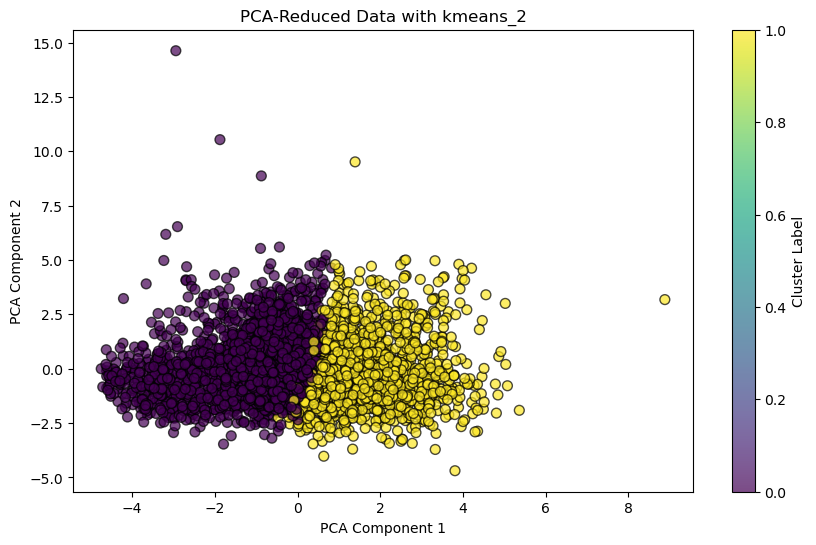

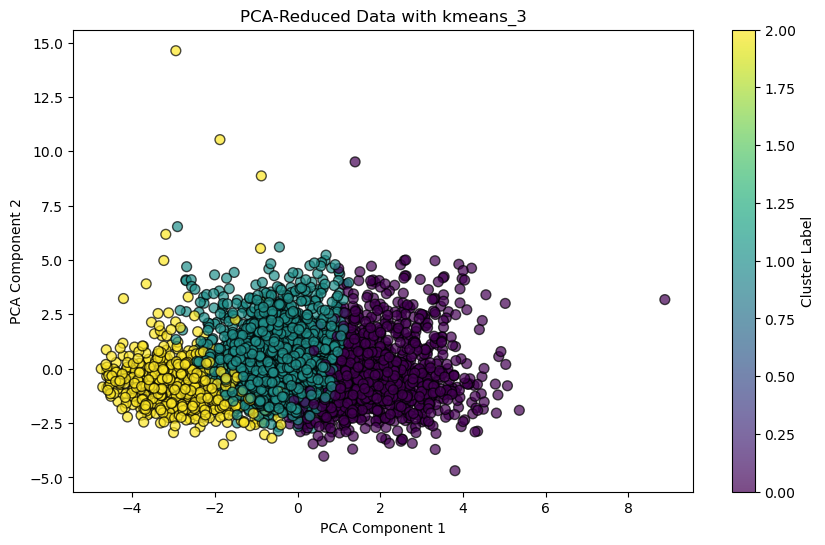

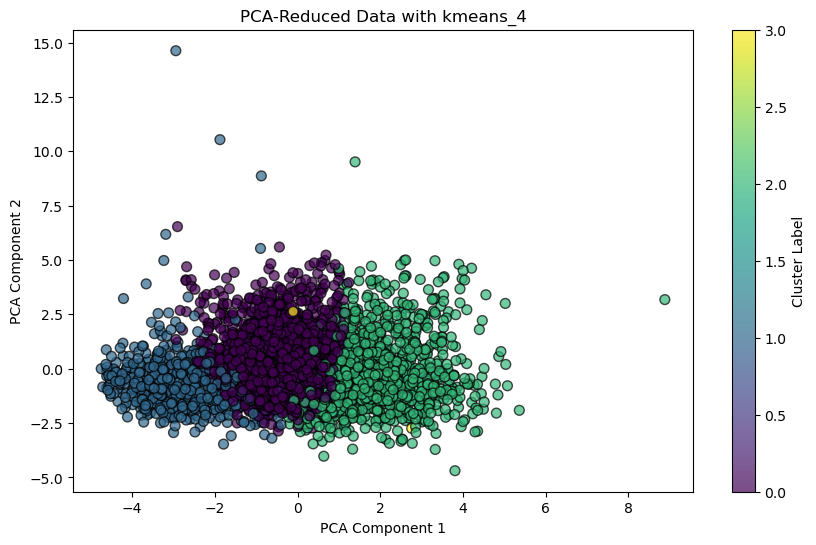

In [51]:
# Plotting the KMeans clustering results
for k, v in kmeans_labels.items():
    plot_cluster_results(X_pca, v, f'PCA-Reduced Data with {k}')

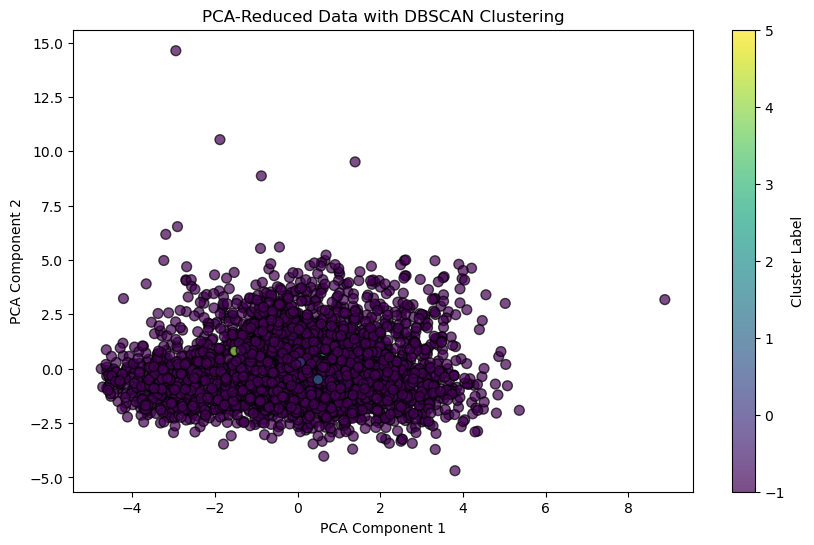

In [52]:
# Plotting the DBSCAN clustering result
plot_cluster_results(X_pca, dbscan_labels, 'PCA-Reduced Data with DBSCAN Clustering')

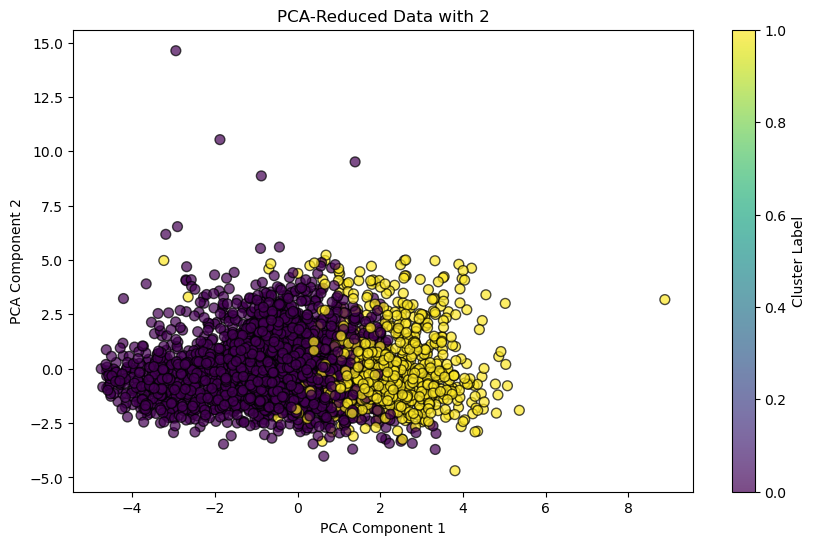

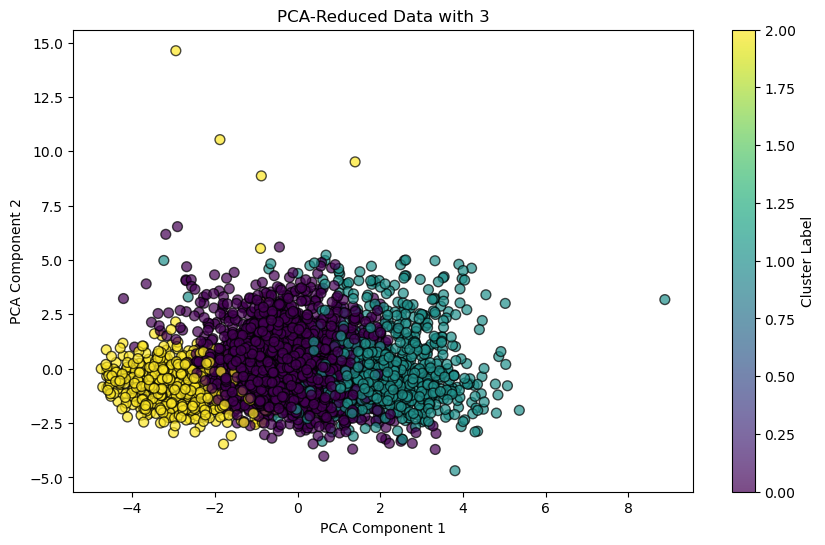

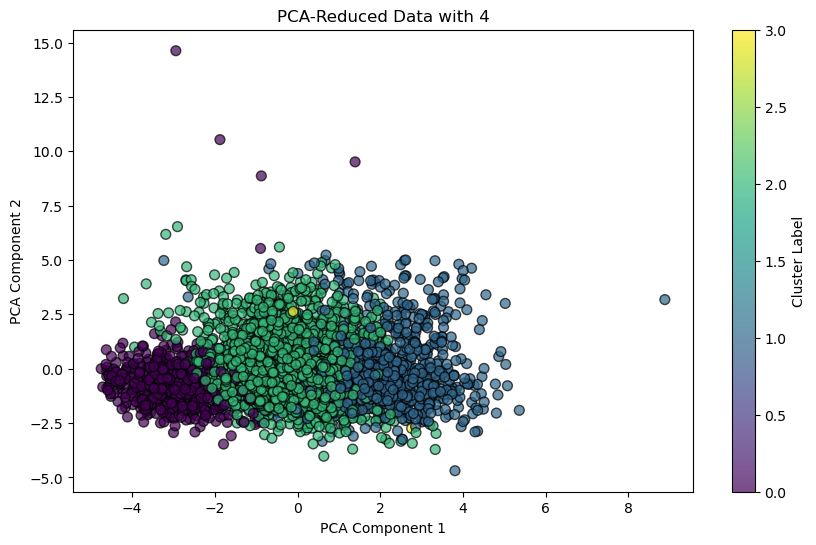

In [56]:
# Plotting the Hierarchical Clustering result
for k, v in agglo_labels.items():
    plot_cluster_results(X_pca, v, f'PCA-Reduced Data with {k}')

In [61]:
# Merging KMeans clustering labels
for n in n_clusters:
    df[f'cluster_kmeans_{n}'] = kmeans_labels[f'kmeans_{n}']

# Merging DBSCAN clustering labels
df['cluster_dbscan'] = dbscan_labels

# Merging Hierarchical Clustering labels
for n in n_clusters:
    df[f'cluster_agglo_{n}'] = agglo_labels[f'{n}']

In [62]:
# Merge KMeans example
df_shp_kmeans = florida_shapefile.merge(df, how='left', left_on='GEOID', right_on='full_ct_fips')

# Merge DBSCAN
df_shp_dbscan = florida_shapefile.merge(df, how='left', left_on='GEOID', right_on='full_ct_fips')

# Merge Hierarchical Clustering example
df_shp_agglo = florida_shapefile.merge(df, how='left', left_on='GEOID', right_on='full_ct_fips')

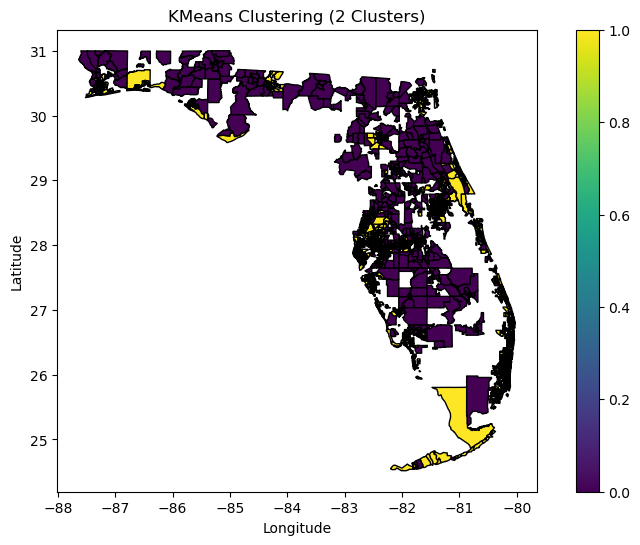

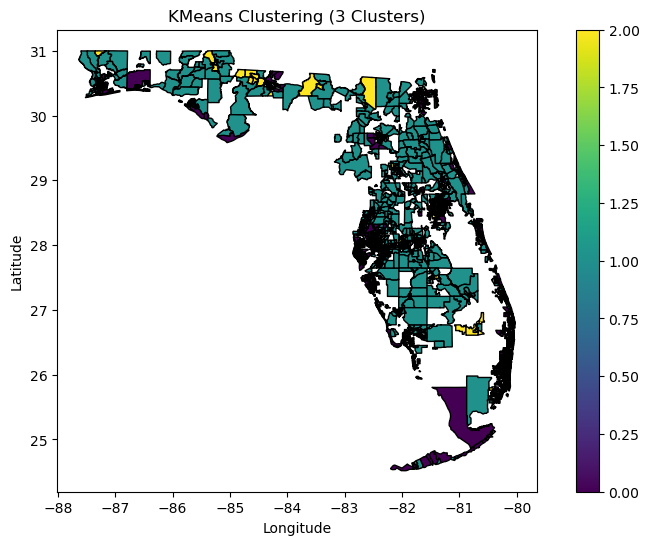

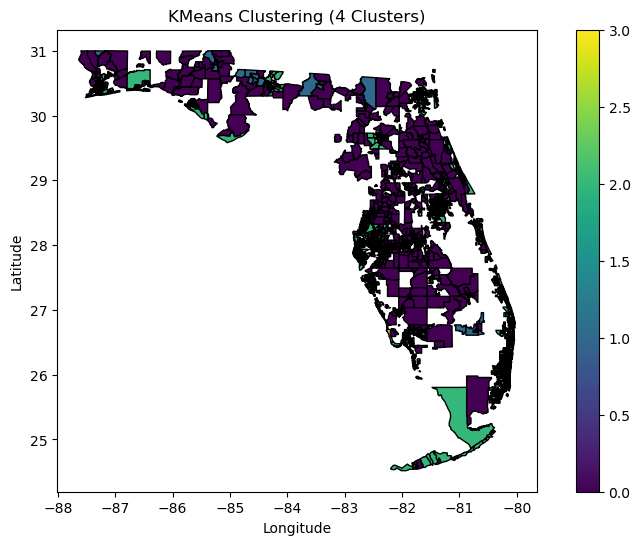

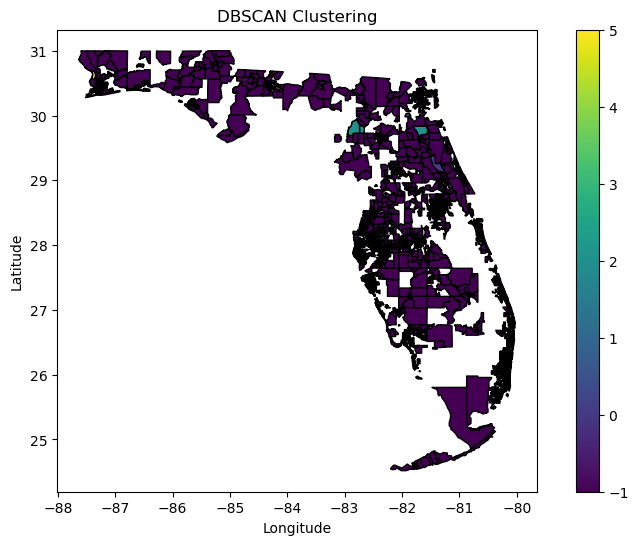

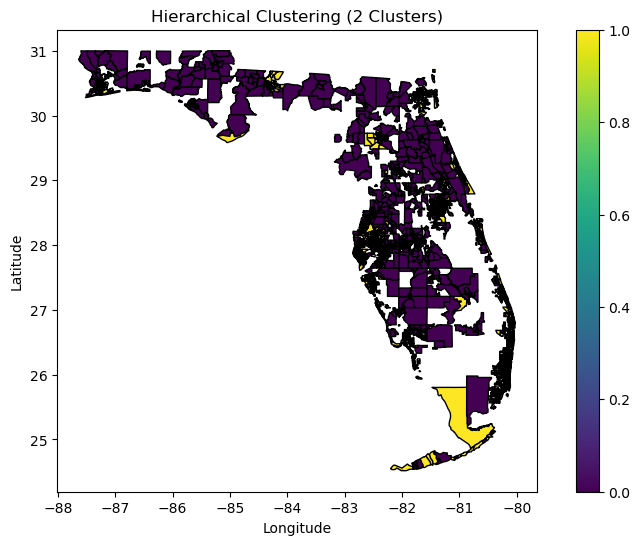

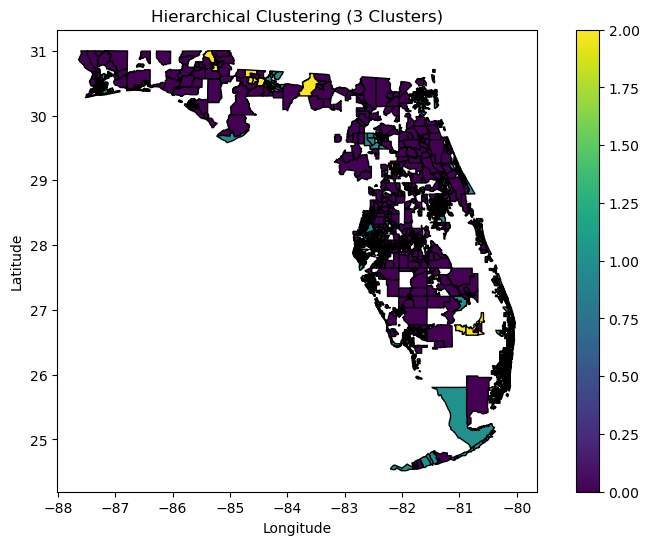

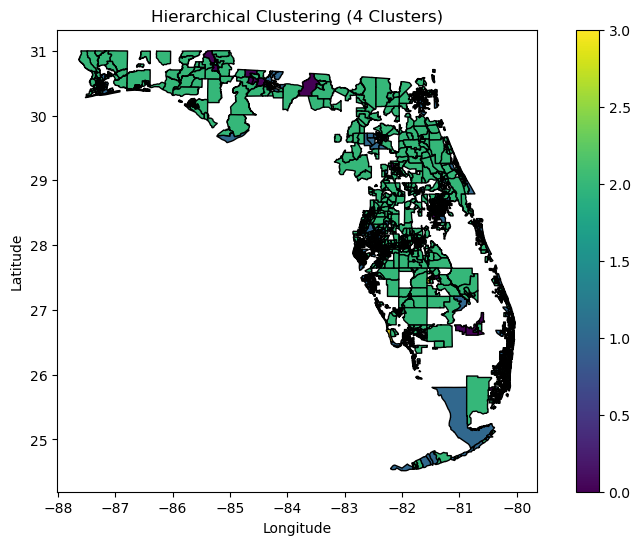

In [65]:
# Function to plot geographical maps with clustering results
def plot_geo_clustering(df_shp, title, cluster_col):
    fig, ax = plt.subplots(1, figsize=(10, 6))
    df_shp.plot(column=cluster_col, ax=ax, legend=True, cmap='viridis', edgecolor='k')
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

# Plotting maps for an example from each clustering type
plot_geo_clustering(df_shp_kmeans, 'KMeans Clustering (2 Clusters)', 'cluster_kmeans_2') 
plot_geo_clustering(df_shp_kmeans, 'KMeans Clustering (3 Clusters)', 'cluster_kmeans_3')
plot_geo_clustering(df_shp_kmeans, 'KMeans Clustering (4 Clusters)', 'cluster_kmeans_4') 
plot_geo_clustering(df_shp_dbscan, 'DBSCAN Clustering', 'cluster_dbscan')
plot_geo_clustering(df_shp_agglo, 'Hierarchical Clustering (2 Clusters)', 'cluster_agglo_2') 
plot_geo_clustering(df_shp_agglo, 'Hierarchical Clustering (3 Clusters)', 'cluster_agglo_3') 
plot_geo_clustering(df_shp_agglo, 'Hierarchical Clustering (4 Clusters)', 'cluster_agglo_4') 

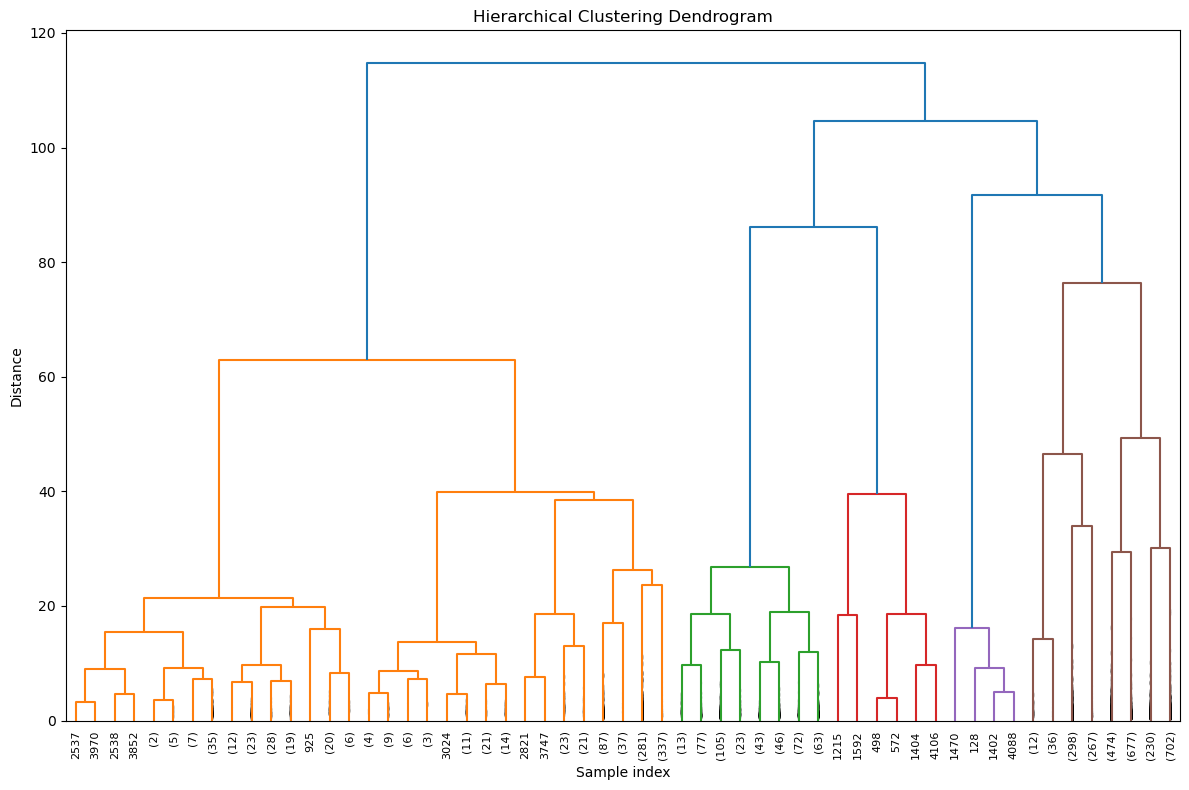

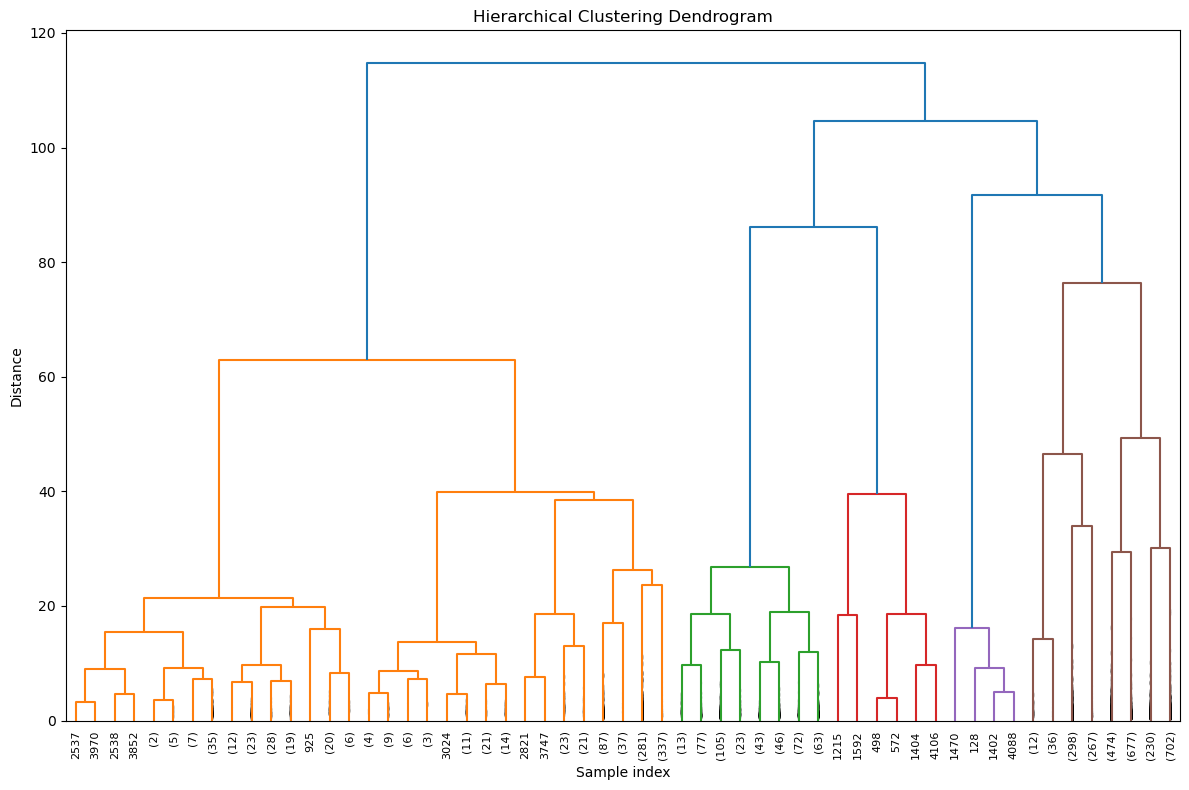

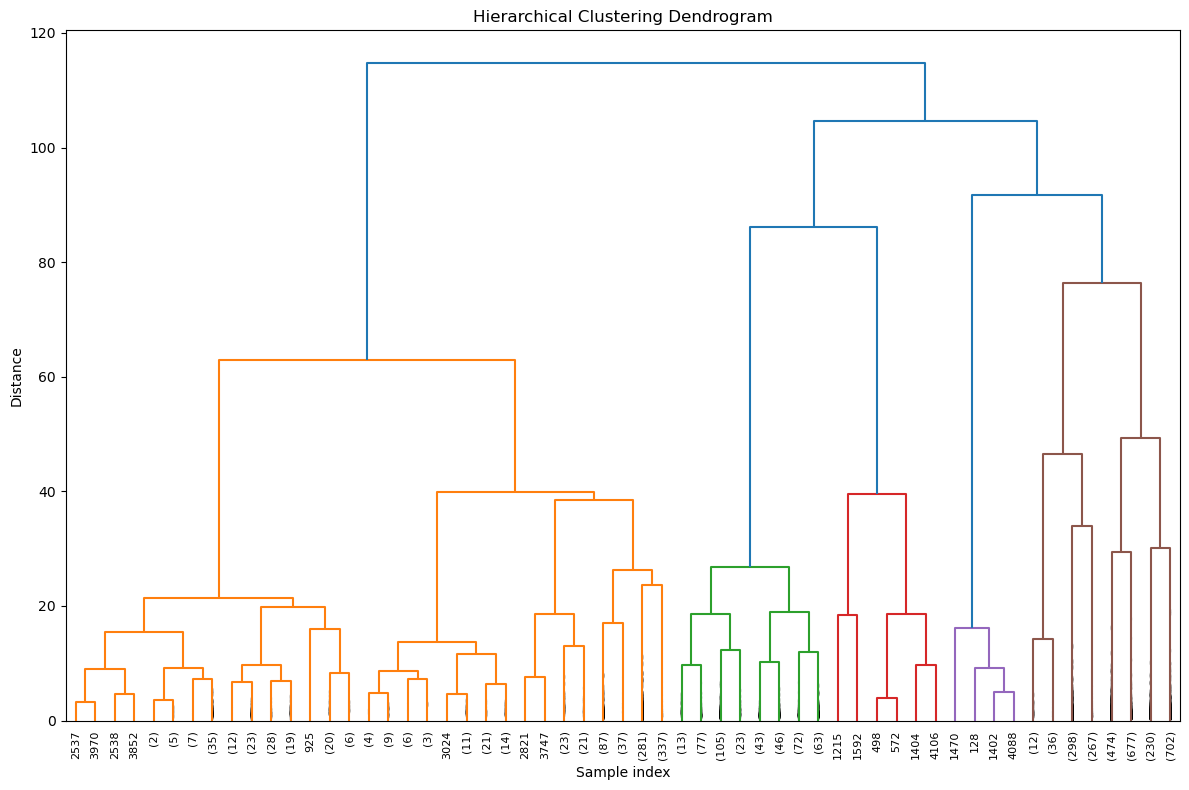

In [68]:
# Perform the hierarchical clustering with different cluster counts
# and generate dendrograms for each.
for n in n_clusters:
    # Compute the linkage matrix
    Z = linkage(X_scaled, method='ward')
    
    # Plot the dendrogram
    plt.figure(figsize=(12, 8))  
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    
    # Truncate the dendrogram for better visibility if necessary
    dendrogram(
        Z,
        leaf_rotation=90.,  # Rotate leaf labels to prevent overlap
        leaf_font_size=8., # Adjust font size for clarity
        show_contracted=True,  # Show a condensed view for large clusters
        truncate_mode='level',  # Truncate the tree by specifying a level
        p=5,  # Number of levels to truncate the tree, adjust based on your dataset
)
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

In [23]:
# Check balance
df_scaled = pd.DataFrame(X_scaled, columns=['travel_driving_ratio', 'edu_bachelor_ratio', 'edu_master_ratio', 'edu_phd_ratio', 'employment_unemployed_ratio', 'household_size_avg', 'inc_median_ind', 'race_black_ratio', 'race_white_ratio', 'sex_male_ratio', 'vehicle_per_capita'])
df_scaled_describe = df_scaled.describe()
print(df_scaled_describe)

       travel_driving_ratio  edu_bachelor_ratio  edu_master_ratio  \
count          4.167000e+03        4.167000e+03      4.167000e+03   
mean           1.304452e-16       -5.115498e-17      2.216716e-17   
std            1.000120e+00        1.000120e+00      1.000120e+00   
min           -9.669478e+00       -2.039703e+00     -1.455905e+00   
25%           -3.234138e-01       -7.999296e-01     -7.692485e-01   
50%            2.196468e-01       -1.215912e-01     -2.291944e-01   
75%            6.227701e-01        7.407605e-01      5.632039e-01   
max            1.433681e+00        6.579179e+00      7.784226e+00   

       edu_phd_ratio  employment_unemployed_ratio  household_size_avg  \
count   4.167000e+03                 4.167000e+03        4.167000e+03   
mean   -2.898782e-17                 1.628434e-16       -3.410332e-18   
std     1.000120e+00                 1.000120e+00        1.000120e+00   
min    -8.345366e-01                -3.239828e+00       -4.550406e-02   
25%    -6.673